# Amplitude of a signal in the presence of background

Adapted from the discussion in Section 3.1 of Sivia and Skilling, *Data Analysis: A Bayesian Tutorial*.

The goal is to estimate the amplitude of a signal when there is background.  We'll take a limiting case where the background is flat, so it is completely specified by its magnitude $B > 0$, and the signal is known to be a Gaussian with unknown amplitude $A$ but (at least initially) known position (mean) and width (standard deviation). The measurements will be integer numbers of counts $\{N_k\}$ in well-defined (equally spaced) bins $\{x_k\}$, where $k$ runs over integers labeling the bins.  Then the goal translates into finding $A$ and $B$ given $\{N_k\}$ and all the other information (bin sizes, signal position and width). After we can modify our goal if we do not care about $B$, or we care only about $B$.

In [1]:
%matplotlib inline  

import numpy as np
from math import factorial

# We'll get our uniform distributions from stats, but there are other ways.
import scipy.stats as stats  
import scipy.integrate as integrate
from scipy import interpolate

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

from mpl_toolkits import mplot3d
from matplotlib import cm

plt.rcParams.update({'font.size': 16})

Set up the true signal plus background magnitudes, and the other parameters dictating the signal (width $w$ and mean $x_0$ of the Gaussian):

$$
   D_k = n_0 \left[ A e^{-(x_k-x_0)^2/2 w^2} + B \right]
$$

Here $n_0$ is a constant that scales with measurement time.  Note that $D_k$ is not an integer in general, unlike $N_k$.

In [2]:
# We'll start with the numbers used by Sivia
A_true = 1.
B_true = 2.
width = np.sqrt(5.)   
x_0 = 0

def exact_data(A, B, n_0, x_k, x_0=0., width=np.sqrt(5.)):
    """
    Return the exact signal plus background.  The overall scale is n_0,
    which is determined by how long counts are collected. 
    """
    return n_0 * (A * np.exp(-(x_k - x_0)**2/(2.*width**2)) + B)

Make a plot of the true signal plus background we are trying to deduce.

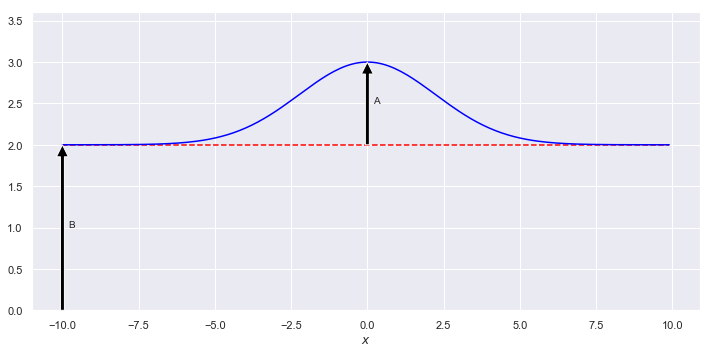

In [3]:
x_min = -10.; x_max = 10.; del_x = 0.1  # range and spacing for plotting
x_pts = np.arange(x_min, x_max, del_x )

n_0 = 1.  # for this plot, the vertical scale is irrelevant
y_pts = exact_data(A_true, B_true, n_0, x_pts, width=width)

fig_true = plt.figure(figsize=(10,5))

ax_true = fig_true.add_subplot(1,1,1)
ax_true.plot(x_pts, B_true*np.ones(len(x_pts)), 
             color='red', linestyle='--')  # just the background
ax_true.plot(x_pts, y_pts, color='blue')   # signal plus background
ax_true.set_ylim(0., 1.2*(A_true + B_true))
ax_true.set_xlabel(r'$x$')

ax_true.annotate('A', xy=(x_0 + 0.2, A_true/2. + B_true))  
ax_true.annotate('', (x_0, B_true + A_true), (x_0, B_true), 
                 arrowprops=dict(facecolor='black', shrink=0.))
ax_true.annotate('B', xy=(-x_max + 0.2, B_true/2.)) 
ax_true.annotate('', (-x_max, B_true), (-x_max, 0), 
                 arrowprops=dict(facecolor='black', shrink=0.))

fig_true.tight_layout()

## Poisson distribution

We are imagining a counting experiment, so the statistics of the counts we record will follow a Poisson distribution.

The Poisson discrete random variable from scipy.stats is defined by (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html))

$$
p(k \mid \mu) = \frac{\mu^k e^{-\mu}}{k!} \quad \mbox{for }k\geq 0 \;.
$$

where $k$ is an integer and $\mu$ is called the shape parameter. The mean and variance of this distribution are both equal to $\mu$. Sivia and Gregory each use a different notation for for this distribution, which means you should be flexible. 



For convenience in comparing to the discussion in Sivia's text, we'll define our own version using his notation in this notebook:

$$
p(N \mid D) = \frac{D^N e^{-D}}{N!} \quad \mbox{for }N\geq 0 \;.
$$

where $N$ is an integer.  The results for the normalization, mean, and variance are:

\begin{align}
 \langle 1 \rangle &= \sum_0^\infty p(N \mid D) = 1 \\
  \langle N \rangle &= \sum_0^\infty N p(N \mid D) = D \\
  \langle N^2 \rangle - \langle N \rangle^2 &= \sum_0^\infty N^2 p(N \mid D) - D^2 = D 
\end{align}

as already noted.  (These are easily verified with Mathematica.  Can you verify them with sympy?)

In [4]:
def poisson(N, D):
    """
    Returns a Poisson distribution value with mean D for integer N.
    We require N to be an integer greater than equal to zero.
    """
    assert (isinstance(N, int) and N >= 0), \
            "N must be a non-negative integer!"

    return D**N * np.exp(-D) / factorial(N) 


Make some plots of Poisson distribution as a function of N, given D.


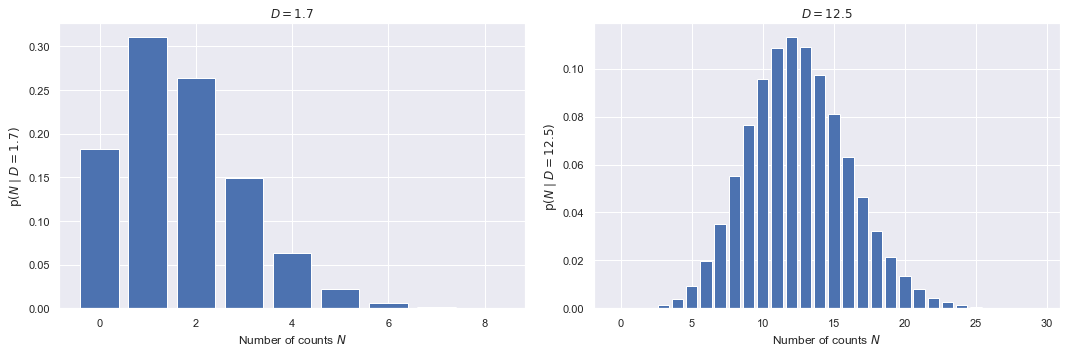

In [5]:
def poisson_plot(ax, D, max_N):
    """
    Make a bar plot on the axis ax of the Poisson distribution for mu = D
    and out to a maximum integer max_N.
    """
    N_pts = np.arange(0, max_N, 1, dtype=int)
    poisson_pts = [poisson(int(N), D) for N in N_pts]
    ax.bar(N_pts, poisson_pts, width=0.8, bottom=None, align='center')
    ax.set_xlabel(r'Number of counts $N$')
    ax.set_ylabel(fr'$\mathrm{{p}}(N \mid D={D:.1f})$')
    ax.set_title(rf'$D = {D:.1f}$')
    return 0

fig = plt.figure(figsize=(15,5))

D1 = 1.7
max_N1 = 9
ax1 = fig.add_subplot(1,2,1)
poisson_plot(ax1, D1, max_N1)

ax2 = fig.add_subplot(1,2,2)
D2 = 12.5
max_N2 = 30
poisson_plot(ax2, D2, max_N2)

fig.tight_layout()

### Follow-ups

* *Try both smaller and larger values of D and note the transition in the form of the pdf.*
* At $D=12.5$ the pdf is already looking like a Gaussian (or what most of us imagine a Gaussian to look like).  *Prove that in the limit $D \rightarrow \infty$ that* 
$$
 p(N \mid D) \stackrel{D\rightarrow\infty}{\longrightarrow} \frac{1}{\sqrt{2\pi D}}e^{-(N-D)^2/(2D)}
$$
You'll want to use Stirling's formula:  $x! \rightarrow \sqrt{2\pi x}e^{-x} x^x$ as $x\rightarrow\infty$.
\[Hint: let $x = N = D(1+\delta)$ where $D\gg 1$ and $\delta \ll 1$.  And use $(1+\delta)^a = e^{a\ln (1+\delta)}$.\]
* *Show that this limit works in practice and visualize how close it is by adding the Gaussian pdf to the plot.* (See [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) or define a function yourself.)

### Preparing data and the pdfs we'll need
For our data, we can get single samples from a scipy.stats Poisson distribution with specified $\mu$ (what we are calling $D$) or an array of samples.  Try running the next cell a few times to get a feel for how the samples fluctuate.

In [6]:
S1 = stats.poisson.rvs(mu=D2)  # sample one Poisson-distributed random number 
print(S1)

S2 = stats.poisson.rvs(mu=D2, size=5)  # sample an array of specified size
print(S2)

17
[10 10 10  9 11]


Once we specify the number and size of the bins for data (and other aspects), we can create a dataset and then make a series of plots as in Sivia.  So define functions to carry these out.

Each of the data $\{N_k\}$ is assumed to be independent of the others, so for $M$ bins:

$$
  p(\{N_k\} \mid A,B,I) = \prod_{k=1}^{M} p(N_k \mid A,B,I)
   = \prod_{k=1}^{M} \frac{D_k^{N_k} e^{-D_k}}{N_k!}
$$

We use this to make the measured dataset based on `A_true` and `B_true`.  This is also what we use to calculate the log likelihood (natural logarithm of this likelihood function), but in that case $A$ and $B$ are not equal to their true values.  We also define a (flat) prior that is *supposed* to be uninformative (*but is it?*).

In [7]:
# make a dataset for exploring
def make_dataset(A_true, B_true, width, x_0, databins, delta_x=1, D_max=100):
    """
    Create a data set based on the number of bins (databins), the spacing
    of bins (delta_x), and the maximum we want the exact result to have
    (D_max, this fixes the n_0 parameter).
    
    Return arrays for the x points (xk_pts), the corresponding values of the
    exact signal plus background in those bins (Dk_pts), the measured values
    in those bins (Nk_pts, integers drawn from a Poisson distribution), the 
    maximum extent of the bins (x_max) and n_0.
    """
    
    # set up evenly spaced bins, centered on x_0
    x_max = x_0 + delta_x * (databins-1)/2
    xk_pts = np.arange(-x_max, x_max + delta_x, delta_x, dtype=int)
    
    # scale n_0 so maximum of the "true" signal plus background is D_max
    n_0 = D_max / (A_true + B_true)  
    Dk_pts = exact_data(A_true, B_true, n_0, xk_pts, width=width)
    
    # sample for each k to determine the measured N_k
    Nk_pts = [stats.poisson.rvs(mu=Dk) for Dk in Dk_pts]
    
    return xk_pts, Dk_pts, Nk_pts, x_max, n_0

In [8]:
# Define the pdfs and combine with Bayes' theorem.
def log_prior(A, B):
    """
    Following Sivia's lead, we take a uniform (flat) prior with large enough
    maximums but, more importantly, require positive values for A and B.
    """
    A_max = 5.
    B_max = 5.
    # flat prior 
    if np.logical_and(A <= A_max, B <= B_max).all(): 
        return np.log(1/(A_max * B_max))
    else:
        return -np.inf

def log_likelihood(A, B, xk_pts, Nk_pts, n_0):
    """Log likelihood for data Nk_pts given A and B"""
    Dk_pts = exact_data(A, B, n_0, xk_pts, width=width)
    try:
        return np.sum(Nk_pts * np.log(Dk_pts) - Dk_pts)
    except ValueError:
        return -np.inf
    
def log_posterior(A, B, xk_pts, Nk_pts, n_0):
    """Log posterior for data Nk_pts given A and B"""
    return log_prior(A, B) + log_likelihood(A, B, xk_pts, Nk_pts, n_0)

def normalize(y_pts, x_pts):
    """Normalize the array y_pts to unity using Simpson's rule."""
    return y_pts / integrate.simps(y_pts, x_pts)

def find_index(x_pts, x_value):
    """Return the index of the element of the ascending array x_pts that
       is closest to x_value.
    """
    return np.fabs(x_pts - x_value).argmin()


### Figures to analyze!

We'll follow Sivia again and make four figures for each case we consider.  (He does this in two groups of two, in figures 3.3 and 3.4.) We consider what happens for fixed signal and background but changing the experimental conditions specified by `D_max` and `databins` (we'll keep `delta_x` fixed to 1).

In [9]:
def find_contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior
       Note: taken from BayesianAstronomy but may not work here.
    """
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return np.sort(sorted_[cutoffs])

def make_figs(databins, delta_x, D_max, flag=False):
    """
    If flag=True, generate another panel of four figures that shows 2. three
    times (contour, shaded contour, 3D) plus showing 68% and 95% intervals.
    Make a panel of four figures:
      1. The data based on sampling the Poisson distribution.  If you rerun
          the function you'll get new data.
      2. The posterior pdf for the amplitude A of the signal and the magnitude
          B of the (flat) background.  Five equally spaced contours are shown.
      3. Posterior for A for two cases: i) marginalized over B, and 
          ii) conditional on known B = B_true.
      4. Posterior for B marginaized over A.
    If flag=True, generate another panel of four figures that shows 2. three
    times (contour, shaded contour, 3D) plus showing 68% and 95% intervals.
    """
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, 
                                                      x_0, databins, delta_x, 
                                                      D_max)
    total_counts = np.sum(Nk_pts)
    
    # Figure 1.
    fig = plt.figure(figsize=(12,10))
    
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(xk_pts, Nk_pts, drawstyle='steps-mid', color='blue')
    ax1.set_xlim(-x_max, x_max)
    ax1.set_ylim(bottom = 0)
    ax1.set_xlabel(r'Measurement variable $x$')
    ax1.set_ylabel(r'Number of counts $N$')
    
    # Figure 2.  Can use contour or contourf.
    A_max = 3.; B_max = 3.
    A_pts = np.arange(0.01, A_max, .02)  # You may want to adjust the density
    B_pts = np.arange(0.01, B_max, .02)  #  of points used.
    A_grid, B_grid = np.meshgrid(A_pts, B_pts)    

    # Z_grid = Z(B, A) the way we define it here with a list comprehension.
    Z_grid = np.array([[log_posterior(A, B, xk_pts, Nk_pts, n_0) 
                        for A in A_pts] for B in B_pts])
    Z_grid = np.exp(Z_grid - np.max(Z_grid))  # normalize the peak to be 1
    ax2 = fig.add_subplot(2,2,2)
    ax2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
    ax2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)

    ax2.contourf(A_grid, B_grid, Z_grid, levels=5, cmap='jet') 
    ax2.set_xlim(0., A_max)
    ax2.set_ylim(0., B_max)
    ax2.set_xlabel(r'Amplitude $A$')
    ax2.set_ylabel(r'Background $B$')
    
    # Figure 3.
    ax3 = fig.add_subplot(2,2,3) 
    B_true_index = find_index(B_pts, B_true)
    B_marginalized = [integrate.simps(Z_grid[:,i], B_pts) \
                                      for i in range(len(A_pts))]
    B_marginalized = normalize(B_marginalized, A_pts)
    B_true_fixed = Z_grid[B_true_index,:]
    B_true_fixed = normalize(B_true_fixed, A_pts)
    ax3.plot(A_pts, B_marginalized, color='blue', 
             label='marginalized over B')
    ax3.plot(A_pts, B_true_fixed, color='red', 
             linestyle='--', label='B = B_true')
    ax3.set_xlabel(r'Amplitude $A$')
    ax3.set_ylabel(r'${\rm p}(A | \{N_k\}, I)$')
    ax3.legend()
    
    # Figure 4.
    ax4 = fig.add_subplot(2,2,4)
    A_marginalized = [integrate.simps(Z_grid[j,:], A_pts) \
                                      for j in range(len(B_pts))]
    A_marginalized = normalize(A_marginalized, B_pts)
    ax4.plot(B_pts, A_marginalized, color='blue',
             label='marginalized over A')
    ax4.set_xlabel(r'Background $B$')
    ax4.set_ylabel(r'${\rm p}(B|\{N_k\}, I)$')
    ax4.legend()
    
    overall_title = f'Total counts = {total_counts},  ' \
                    + f'# of bins = {databins}' \
                    + '\n'
    fig.suptitle(overall_title, y=1.01)
    
    fig.tight_layout()
    
    if (flag):
        fig2 = plt.figure(figsize=(12,10))
        # Figure 1.
        ax2_1 = fig2.add_subplot(2,2,1)
        contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
        ax2_1.contour(A_grid, B_grid, Z_grid, levels=contour_levels)
        ax2_1.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_1.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_1.set_xlim(0., A_max)
        ax2_1.set_ylim(0., B_max)
        ax2_1.set_xlabel(r'Amplitude $A$')
        ax2_1.set_ylabel(r'Background $B$')
        ax2_1.set_title('Contour plot with levels 0.2, 0.4, 0.6, 0.8, 1.0')
        
        # Figure 2.
        ax2_2 = fig2.add_subplot(2,2,2)
        ax2_2.contourf(A_grid, B_grid, Z_grid, levels=5, cmap='jet') 
        ax2_2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.set_xlim(0., A_max)
        ax2_2.set_ylim(0., B_max)
        ax2_2.set_xlabel(r'Amplitude $A$')
        ax2_2.set_ylabel(r'Background $B$')
        ax2_2.set_title('Color contour plot with contourf')
        
        # Figure 3.
        ax2_3 = fig2.add_subplot(2,2,3, projection='3d')
        ax2_3.plot_surface(A_grid, B_grid, Z_grid, rstride=1, cstride=1, 
                           cmap='jet', linewidth=0, antialiased=False,
                           edgecolor='none')
        ax2_3.set_xlim(0., A_max)
        ax2_3.set_ylim(0., B_max)
        ax2_3.set_xlabel(r'Amplitude $A$')
        ax2_3.set_ylabel(r'Background $B$')
        ax2_3.set_title('Surface plot')
        
        # Figure 4.
        ax2_4 = fig2.add_subplot(2,2,4)
        ax2_4.contour(A_grid, B_grid, Z_grid, 
                      levels=find_contour_levels(Z_grid))
        ax2_2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_4.set_xlim(0., A_max)
        ax2_4.set_ylim(0., B_max)
        ax2_4.set_xlabel(r'Amplitude $A$')
        ax2_4.set_ylabel(r'Background $B$')
        ax2_4.set_title('Contours at 68%, 95%, 99.7%')
        fig2.tight_layout()
                
    return fig

Ok, let's do it.  For each of the examples (and more that you invent):

* Make sure to run them multiple times to get a few for the fluctuations. *What features are stable and what varies wildly (will change depending on the example!).*
* *Interpret the change in the width of the contours in the different cases.*
* *What do the slopes of the posterior ellipses (2nd figures) tell us?  Can you account for the behavior in the different cases?*
* *Interpret the difference between the solid and dashed lines in the plots that marginalize over $B$ with two opposite limits of the prior knowledge of $B$ (3rd figures).*
* *What are your conclusions for how to design the experiment given limited resources?*
* *Follow-up task: check whether the size of the bin matters in the four figures.

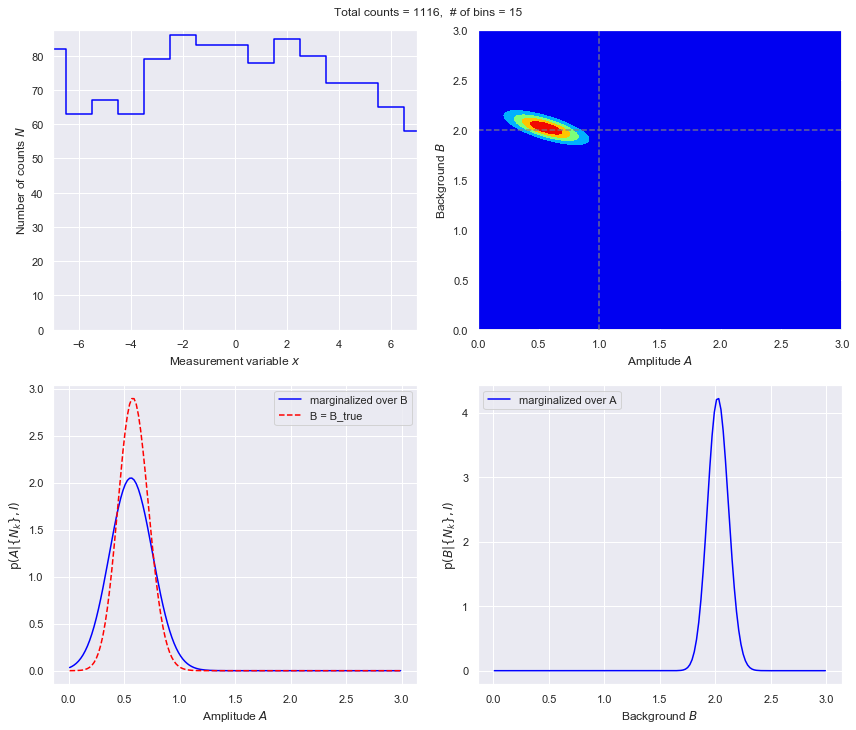

In [10]:
# Baseline case: 15 bins and maximum expection of 100 counts.

D_max = 100
databins = 15
delta_x = 1

fig = make_figs(databins, delta_x, D_max, flag=False)

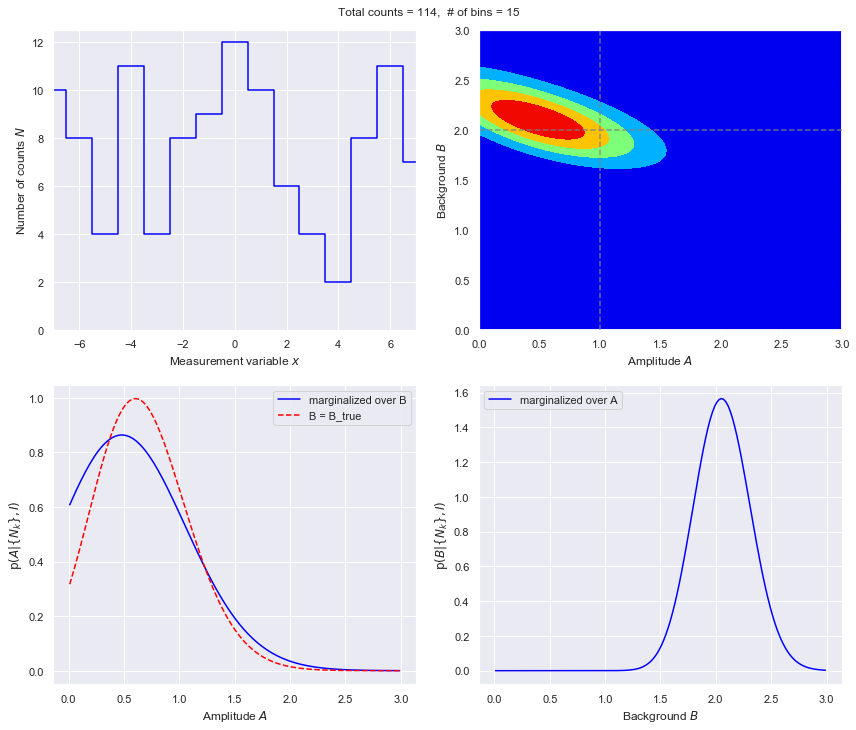

In [11]:
# Less data case: 15 bins and maximum expection of only 10 counts.

D_max = 10
databins = 15
delta_x = 1

fig = make_figs(databins, delta_x, D_max, flag=False)

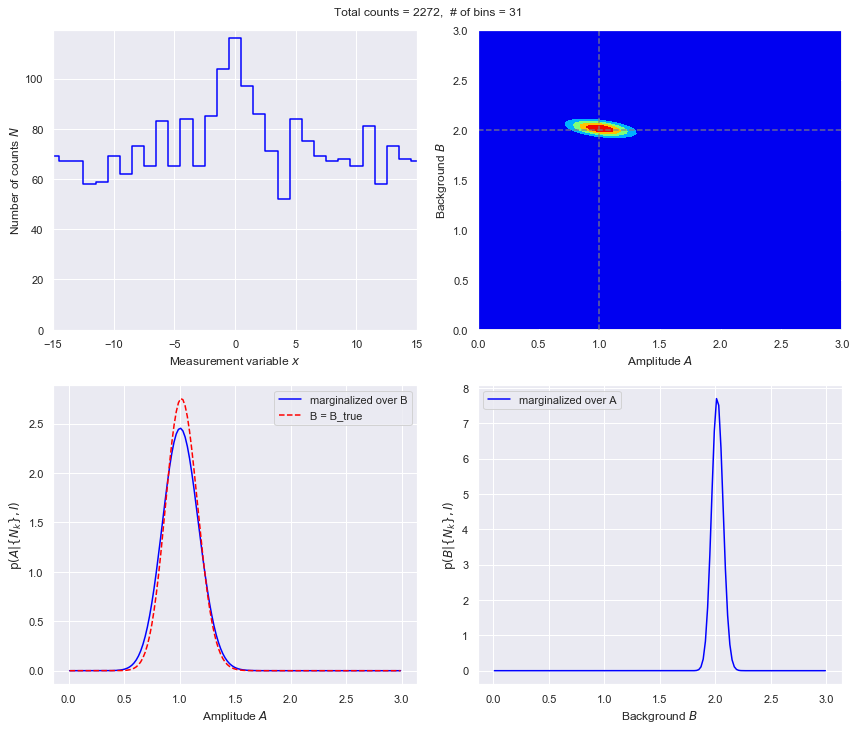

In [12]:
# Greater range case: 31 bins (with fixed bin width) 
# and same maximum expection of 100 counts as in baseline case.

D_max = 100
databins = 31
delta_x = 1

fig = make_figs(databins, delta_x, D_max, flag=False)

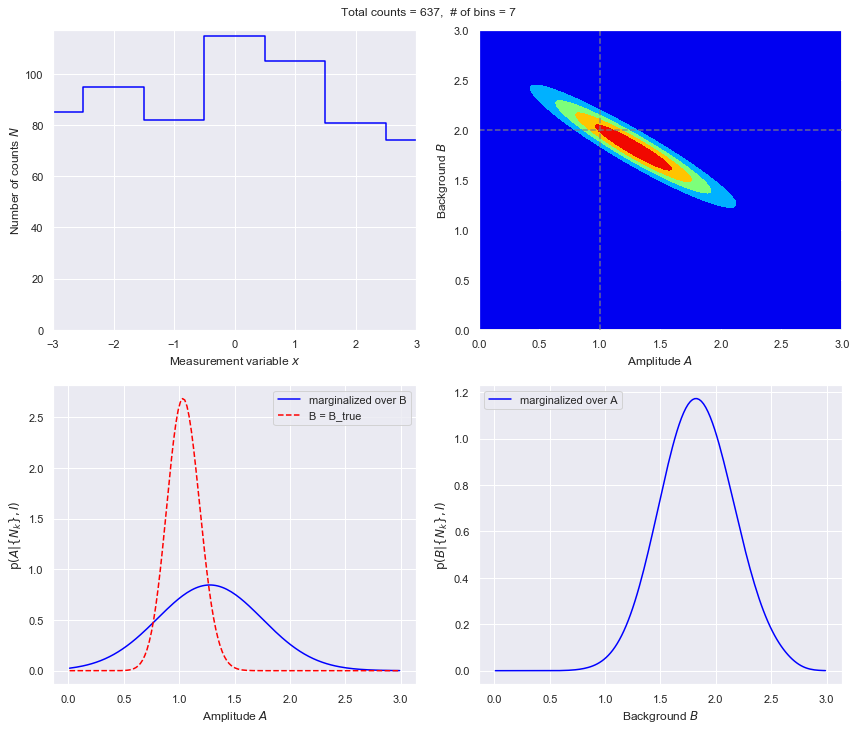

In [14]:
# Same as baseline and last case except now only 7 bins.

D_max = 100
databins = 7
delta_x = 1

fig = make_figs(databins, delta_x, D_max, flag=False)